<a href="https://colab.research.google.com/github/shadiakiki1986/ml-competitions/blob/master/replicated_papers/190565-supervised_learning_of_snn/t3d_cleaned_code_without_any_preloading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Replicate Figure <strike>1</strike> 2 of Supervised learning in spiking neural networks with FORCE training
https://www.nature.com/articles/s41467-017-01827-3

Copy from tensorflow implementation of SNN and <strike>modify for the rate equations provided in the paper</strike> from the open-source code of the paper (github + ModelDB)

Note that https://www.tensorflow.org/tutorials/non-ml/pdes has a good example on how to use tensorflow for PDEs

Based on https://github.com/ModelDBRepository/190565/blob/master/CODE%20FOR%20FIGURE%202/THETAFORCESINE.m


In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
%matplotlib inline


In [0]:

## Model parameters
#dt = .01 # 0.00001 # time step
dt = 10e-6 # 0.00001 # time step # 0.01 will unstabilize the simulation upon "current" input
N = 2000 # network size
td = 0.02 # decay time
tr = .002 # rise time

T = 15e5*dt #15
tmin = 5e5*dt #5
tcrit = 10e5*dt # 10
tx = np.arange(dt, T, dt)
G = 10
Q = 10000

#%% Compute Neuronal Intercepts and Tuning Curves 
initial = 0
p = 0.1 # ; %Sparse Coupling 


vpeak = math.pi#; %peak and reset
vreset = -math.pi#;

j = 1;
ns = 0;
SD = 0;
rls_step = 50#; %Sets the frequency of RLS  

#list(range(len(tx)))[-1]

input shape (1499999, 1)


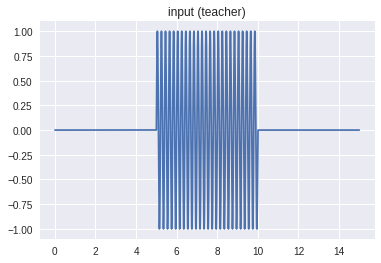

In [0]:

# input
xz = np.sin(2*tx*math.pi*5).reshape(-1,1) # input
xz[(tx<tmin) | (tx>tcrit),0]=0
m = 1 # xz.shape.min() # dimensionality of teacher 

plt.plot(tx, xz)
plt.title("input (teacher)")

print("input shape", xz.shape)

In [0]:
# initializers for the graph variables or constants
v_init = vreset + (vpeak-vreset)*np.random.uniform(size=(N,1))#; %initialze voltage as per original paper
# v_init = np.ones([N, 1]) * -70.0  # jotia1 uses -70mV starting condition
# v_init = v_init / 10 # reduce the v_init to avoid having to wait 5 seconds for the network to cool down FIXME

OMEGA_init = G*np.random.normal(size=(N,N))
OMEGA_init = np.multiply(np.random.uniform(N,N)<p, OMEGA_init) # keep only uniform random selection of values with probability p
OMEGA_init = OMEGA_init/(math.sqrt(N)*p)
OMEGA_init  = OMEGA_init - OMEGA_init.mean(axis=1).reshape(-1,1).repeat(OMEGA_init.shape[1], axis=1)

v_init.shape, OMEGA_init.shape

((2000, 1), (2000, 2000))

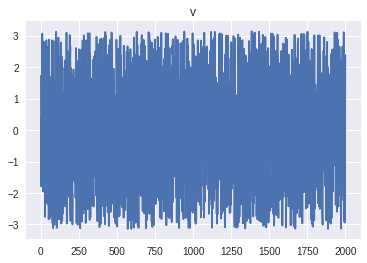

In [0]:
plt.plot(v_init)
plt.title("v")
plt.show()


In [0]:

## Make graph
with tf.Graph().as_default() as tf_graph:
    
    ## inputs
    I_app = tf.placeholder(tf.float32, shape=[m, 1])
    do_train = tf.placeholder(tf.bool, shape=[N, m])
    
    ## Variables in model
    # voltage
    v = tf.Variable(tf.ones(shape=v_init.shape) * v_init, dtype=tf.float32, name='v')
    # current
    z = tf.Variable(tf.zeros(shape=(m,1), dtype=tf.float32), name='z')
    # boolean whether a neuron fired or not
    fired = tf.Variable(tf.zeros(v_init.shape, dtype=bool), dtype=tf.bool, name='fired')
    # ;  %Decoders
    BPhi = tf.Variable(tf.zeros(shape=(N,m)), dtype=tf.float32, name='BPhi')
    # post-synaptic current
    IPSC = tf.Variable(tf.zeros(shape=(N,1)), dtype=tf.float32, name='IPSC')
    # other
    h  = tf.Variable(tf.zeros(shape=(N,1)), dtype=tf.float32, name='h')
    r  = tf.Variable(tf.zeros(shape=(N,1)), dtype=tf.float32, name='r')
    hr = tf.Variable(tf.zeros(shape=(N,1)), dtype=tf.float32, name='hr')
    Pinv = tf.Variable(tf.eye(N)*dt, dtype=tf.float32, name='Pinv')
    err = tf.Variable(tf.zeros(shape=(m,1)), dtype=tf.float32, name='err')
    cd = tf.Variable(tf.zeros(shape=(N,1)), dtype=tf.float32, name='cd')
    
    ## Other inputs
    # encoders
    E = Q*(2*tf.random.uniform([N,m])-1)

    # ; %Random initial weight matrix 
    # %Set the sample row mean of the weight matrix to be 0 to strictly enforce
    # %balance.  
    OMEGA = tf.constant(OMEGA_init, dtype=tf.float32, name='OMEGA')


    ## Computation
    JX = tf.add(IPSC, tf.matmul(E, z)) #; %current 
    dv = tf.add(
        1 - tf.math.cos(v),
        tf.multiply(
          1 + tf.math.cos(v),
          JX * (math.pi**2)
        )
    )
    v_updated = v + dv*dt
    
    # Deal with spikes
    # Limit anything above threshold to threshold value (35)
    # We are saving which fired to use again in the next iteration
    fired_updated = tf.greater_equal(v_updated, tf.ones(tf.shape(v)) * vpeak)

    # ; %compute the increase in current due to spiking  
    JD = tf.math.reduce_sum(
        tf.boolean_mask(
          OMEGA,
          tf.squeeze(fired_updated),
          axis=1
        ),
        axis=1,
        keepdims=True
    )

    # Integrate the current
    IPSC_updated = IPSC * tf.exp(-dt/tr) + h*dt
    h_updated = h * tf.exp(-dt/td) + JD / tr / td
    r_updated = tf.add(
      r * tf.exp(-dt/tr), # + or tf.add (since vectors) ?
      hr*dt
    )
    hr_updated = tf.where(
        fired_updated,
        hr * tf.exp(-dt/td) + 1/tr/td,
        hr * tf.exp(-dt/td)
    )

    # update voltage and current
    v_updated = tf.where(fired_updated, tf.ones(tf.shape(v)) * vreset, v_updated)
    z_updated = tf.matmul(tf.transpose(BPhi), r_updated)
    
    # now perform optimization step to update BPhi and Pinv
    err_updated = tf.subtract(z_updated, I_app) # output current should match with input current
    cd_ = tf.matmul(Pinv, r_updated)
    BPhi_updated = tf.where(
        do_train, 
        tf.subtract(BPhi, tf.matmul(cd_, tf.transpose(err_updated))),
        BPhi
    )
    #print("cd_", cd_, "r_updated", r_updated)
    #print("r", r, "Pinv", Pinv)
    #print("Pinv_deno", Pinv_deno)
    Pinv_deno = (1 + tf.matmul(tf.transpose(r_updated), cd_))
    do_train2 = tf.cast(do_train, dtype=tf.float32)
    do_train2 = tf.matmul(do_train2, tf.transpose(do_train2))
    do_train2 = tf.cast(do_train2, dtype=tf.bool)
    #print("do_train", do_train, "do_train2", do_train2)
    Pinv_updated = tf.where(
        do_train2,
        tf.subtract(
          Pinv,
          tf.matmul(cd_, tf.transpose(cd_)) / Pinv_deno
        ),
        Pinv
    )
    
    # i.e. from https://www.tensorflow.org/tutorials/non-ml/pdes "# Operation to update the state"
    state_ops = tf.group(
      # all ops for voltage/current
      IPSC.assign(IPSC_updated),
      BPhi.assign(BPhi_updated),
      Pinv.assign(Pinv_updated),
      h.assign(h_updated),
      r.assign(r_updated),
      hr.assign(hr_updated),
        
      # finally perform voltage/current update of variables
      v.assign(v_updated),
      z.assign(z_updated),
      fired.assign(fired_updated),
        
      # other internal variables
      err.assign(err_updated),
      cd.assign(cd_)
    )

    


Instructions for updating:
Colocations handled automatically by placer.


In [0]:
record_step = 1000 # int(1000*dt/dt) # int(1/dt) # 10 # record data every n steps to avoid running out of memory

1000

In [0]:
vs = []
zs = []
bps = []
rs=[]
ss=[]
es=[]
cds=[]
hrs=[]
pinvs=[]

#      current = np.zeros(tx.shape[0],m)#;  %storage variable for output current 
#      IPSC = np.zeros(N,1)#; %post synaptic current 

#      REC
#      RECB
#      z
      
import time


In [0]:
# with tf.Session(graph=tf_graph) as sess:
sess = tf.InteractiveSession(graph=tf_graph)

# Comment out to avoid "restarting"
sess.run(tf.global_variables_initializer())

In [0]:
for ti in range(len(tx)):    ## Timesteps
  if (ti % record_step) == 0: print("%i / %i .. %0.4f sec .. %s" % (ti, len(tx), tx[ti], time.ctime()))
  xzi = xz[ti,:].reshape(1,-1)
  do_train_scalar = (tx[ti]>tmin) & (tx[ti]<tcrit) & ((ti%rls_step)==1)
  sess.run(
   state_ops,
   feed_dict={
      I_app: xzi,
      do_train: do_train_scalar.reshape(1,m).repeat(N, axis=0),
   }
  )

  # evaluate every 10 steps
  if (ti % record_step) == 0:
    vs.append(v.eval())
    zs.append(z.eval())

    # Useless to store firing points at subsampling
    # because this would miss spikes that are not aligned with the subsampling
    # Unless we gather all steps between "record_steps"
    # and mark a spike if any point has spiked
    # ss.append(fired.eval())

    # other variables
    #bps.append(BPhi.eval())
    #rs.append(r.eval())
    #es.append(err.eval())
    #cds.append(cd.eval())
    #hrs.append(hr.eval())
    #pinvs.append(Pinv.eval())

500000 / 1499999 .. 5.0000 sec .. Wed Feb  6 12:32:25 2019
501000 / 1499999 .. 5.0100 sec .. Wed Feb  6 12:32:28 2019
502000 / 1499999 .. 5.0200 sec .. Wed Feb  6 12:32:31 2019
503000 / 1499999 .. 5.0300 sec .. Wed Feb  6 12:32:34 2019
504000 / 1499999 .. 5.0400 sec .. Wed Feb  6 12:32:37 2019
505000 / 1499999 .. 5.0500 sec .. Wed Feb  6 12:32:41 2019
506000 / 1499999 .. 5.0600 sec .. Wed Feb  6 12:32:44 2019
507000 / 1499999 .. 5.0700 sec .. Wed Feb  6 12:32:47 2019
508000 / 1499999 .. 5.0800 sec .. Wed Feb  6 12:32:50 2019
509000 / 1499999 .. 5.0900 sec .. Wed Feb  6 12:32:53 2019
510000 / 1499999 .. 5.1000 sec .. Wed Feb  6 12:32:56 2019
511000 / 1499999 .. 5.1100 sec .. Wed Feb  6 12:32:59 2019
512000 / 1499999 .. 5.1200 sec .. Wed Feb  6 12:33:02 2019
513000 / 1499999 .. 5.1300 sec .. Wed Feb  6 12:33:05 2019
514000 / 1499999 .. 5.1400 sec .. Wed Feb  6 12:33:08 2019
515000 / 1499999 .. 5.1500 sec .. Wed Feb  6 12:33:11 2019
516000 / 1499999 .. 5.1600 sec .. Wed Feb  6 12:33:14 20

In [0]:
len(vs), len(zs), len(bps), len(rs), len(ss), len(es)

(1501, 1501, 0, 0, 0, 0)

In [0]:
# make new time axis that is subsampled for the recording frequency
tx2 = tx[::record_step]
tx.shape, tx2.shape

((1499999,), (1500,))

In [0]:
#len(vs), vs[0].shape
#len(zs), zs[0].shape
vv = np.concatenate(vs, axis=1)[:, :tx2.shape[0]]
zv = np.concatenate(zs, axis=1)[:, :tx2.shape[0]]
#sv = np.concatenate(ss, axis=1)

vv.shape, zv.shape # , sv.shape

((2000, 1500), (1, 1500))

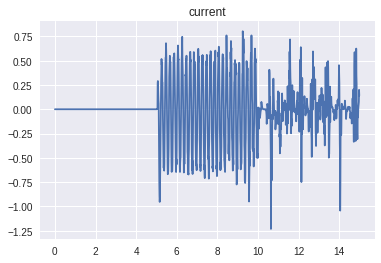

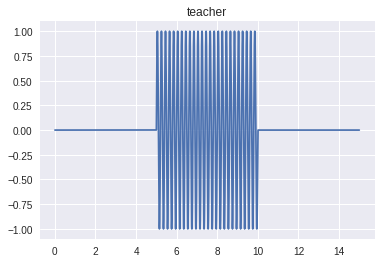

'\nplt.plot(tx2, ev.transpose(), \'--\')\nplt.title("err")\nplt.show()\n'

In [0]:
plt.plot(tx2, zv.transpose())
plt.title("current")
plt.show()

plt.plot(tx, xz)
plt.title("teacher")
plt.show()

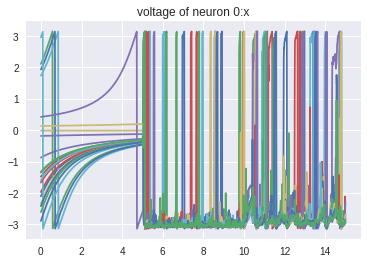

In [0]:
plt.plot(tx2, vv[0:20,:].transpose())
plt.title("voltage of neuron 0:x")
plt.show()

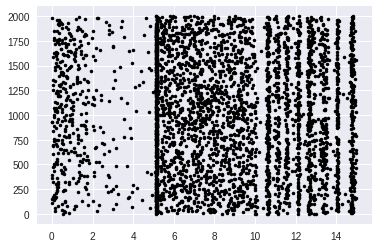

In [0]:
#plt.plot(tx, range(N), sv)
#plt.title("fired matrix")
#plt.show()


#inha, inhb = np.nonzero(sv.transpose())
inha, inhb = np.nonzero((vv >= vpeak-.01).transpose()) # approximate firing from voltages
plt.plot(tx2[inha], inhb, 'k.')
plt.show()

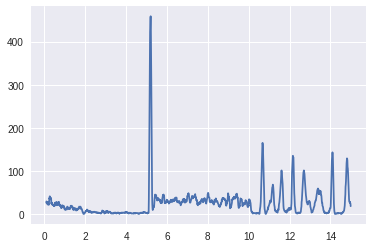

In [0]:
# plot of number of neurons firing
# approximate firing from voltages

import pandas as pd
fire_count = (vv >= vpeak-.01).sum(axis=0)

# moving average
# n=10 corresponds to 0.1 seconds at dt=10e-6
fire_count = pd.Series(fire_count).rolling(10).sum()

# plot
plt.plot(tx2, fire_count)
plt.show()